# ViT MAE notebook (test and finetuning)

In this notebook, we test and finetune the ViT MAE network that we aim to use to obtain features from images. These features will then be the inputs to our main network (containing the RAN network). Since the features are the main input to our network, we aim at obtaining features which are representative of the input image, and which retain a significant amount of information.

First of all, we install the necessary libraries.

In [ ]:
!pip install -q transformers
!pip install -q torchvision
!pip install -q pillow
!pip install huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 67.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


We then install all the libraries needed to run the notebook.

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, transforms
from transformers import ViTFeatureExtractor, ViTMAEForPreTraining, ViTConfig
from torch.utils.data import Dataset
import os

We define a class for the dataset.

In [ ]:
class SimDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        return image, image_path

We mount Google Drive to retrieve our dataset (images taken by videos navigating in environments in Habitat Sim).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We then login to the HuggingFace Hub, since we would like to push the finetuned ViT MAE model.

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

At this point, we define the paths of the individual images that we will use to finetune the ViT MAE model.

In [ ]:
folder_path = "/content/drive/MyDrive/shortest_path_videos/frames/"
file_names = os.listdir(folder_path)
image_extensions = [".jpg", ".jpeg", ".png"]
image_paths = [os.path.join(folder_path, file_name) for file_name in file_names if os.path.splitext(file_name)[-1].lower() in image_extensions]

Then, we split our dataset (containing images captured by an active agent navigating in environments in Habitat Sim) in a training dataset and a validation/test dataset.

In [ ]:
from sklearn.model_selection import train_test_split
image_paths, image_paths_test = train_test_split(image_paths, test_size=0.2, random_state=42)

We define the device, so that we speed up the finetuning if a GPU is available.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We now load the dataset and the model, and finetune the ViT MAE on our dataset. In this configuration, we freeze all layers but the last TransformerBlock in the encoder. At the end of the finetuning, we save the finetuned model on the HuggingFace Hub.

In [ ]:
# Loading a sample dataset
transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor()])
dataset = SimDataset(image_paths, transform=transform)

loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

# Loading the model and setting up feature extractor
model = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")
model.to(device)
feature_extractor = ViTFeatureExtractor.from_pretrained("facebook/vit-mae-base")

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last TransformerBlock in the encoder
for param in model.vit.encoder.layer[-1].parameters():
    param.requires_grad = True

# Fine-tuning the autoencoder
epochs = 2
lr = 1e-6
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

for epoch in range(epochs):
    for batch_idx, (data, _) in enumerate(loader):
        data = data.to(device)
        pixel_values = feature_extractor(images=data, return_tensors="pt").pixel_values
        pixel_values = pixel_values.to(device)
        outputs = model(pixel_values)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f"Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item()}")

# Saving the model
model.save_pretrained("habitat_fine_tuned_vit_mae_base_frozen")

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Epoch: 0, Batch: 0, Loss: 6.197307084221393e-05
Epoch: 1, Batch: 0, Loss: 3.968465171055868e-05


We now load the dataset and the model, and finetune the ViT MAE on our dataset. In this configuration, all the layers are not frozen and are therefore free to be finetuned. At the end of the finetuning, we save the finetuned model on the HuggingFace Hub.

In [ ]:
# Loading a sample dataset
transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor()])
dataset = SimDataset(image_paths, transform=transform)

loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

# Loading the model and setting up feature extractor
model = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")
model.to(device)
feature_extractor = ViTFeatureExtractor.from_pretrained("facebook/vit-mae-base")

# Fine-tuning the autoencoder
epochs = 2
lr = 1e-6
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(epochs):
   for batch_idx, (data, _) in enumerate(loader):
       data = data.to(device)
       pixel_values = feature_extractor(images=data, return_tensors="pt").pixel_values
       pixel_values = pixel_values.to(device)
       outputs = model(pixel_values)
       loss = outputs.loss

       optimizer.zero_grad()
       loss.backward()
       optimizer.step()

       if batch_idx % 100 == 0:
           print(f"Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item()}")

# Saving the model
model.save_pretrained("habitat_fine_tuned_vit_mae_base_not_frozen")

Epoch: 0, Batch: 0, Loss: 9.254134056391194e-05
Epoch: 1, Batch: 0, Loss: 7.602083769597812e-06


In the next cells, we save the two finetuned models to HuggingFace Hub, so that they can be retrieved (and used) later.

In [ ]:
!huggingface-cli repo create "habitat_fine_tuned_vit_mae_base_frozen"

git version 2.25.1
git-lfs/2.9.2 (GitHub; linux amd64; go 1.13.5)

You are about to create lucazed/habitat_fine_tuned_vit_mae_base_frozen
Proceed? [Y/n] Y

Your repo now lives at:
  https://huggingface.co/lucazed/habitat_fine_tuned_vit_mae_base_frozen

You can clone it locally with the command below, and commit/push as usual.

  git clone https://huggingface.co/lucazed/habitat_fine_tuned_vit_mae_base_frozen



In [ ]:
import os
import shutil
from huggingface_hub import Repository

# Set these to your own values
your_model_name = "habitat_fine_tuned_vit_mae_base_frozen"
your_hf_username = "lucazed"

# Create a temporary directory
temp_dir = "temp_dir"
os.makedirs(temp_dir, exist_ok=True)

# Create a local clone of the repository in the temporary directory
repo = Repository(local_dir=temp_dir, clone_from=f"{your_hf_username}/{your_model_name}")

# Save the model to the local clone
model.save_pretrained(repo.local_dir)

# Commit and push the changes to the remote repository
repo.push_to_hub(commit_message="Initial model upload")

# Remove the temporary directory
shutil.rmtree(temp_dir)

Cloning https://huggingface.co/lucazed/habitat_fine_tuned_vit_mae_base_frozen into local empty directory.


Upload file pytorch_model.bin:   0%|          | 1.00/427M [00:00<?, ?B/s]

To https://huggingface.co/lucazed/habitat_fine_tuned_vit_mae_base_frozen
   3a66f95..4b55733  main -> main

   3a66f95..4b55733  main -> main



In [ ]:
!huggingface-cli repo create "habitat_fine_tuned_vit_mae_base_not_frozen"

git version 2.25.1
git-lfs/2.9.2 (GitHub; linux amd64; go 1.13.5)

You are about to create lucazed/habitat_fine_tuned_vit_mae_base_not_frozen
Proceed? [Y/n] Y

Your repo now lives at:
  https://huggingface.co/lucazed/habitat_fine_tuned_vit_mae_base_not_frozen

You can clone it locally with the command below, and commit/push as usual.

  git clone https://huggingface.co/lucazed/habitat_fine_tuned_vit_mae_base_not_frozen



In [ ]:
import os
import shutil
from huggingface_hub import Repository

# Set these to your own values
your_model_name = "habitat_fine_tuned_vit_mae_base_not_frozen"
your_hf_username = "lucazed"

# Create a temporary directory
temp_dir = "temp_dir"
os.makedirs(temp_dir, exist_ok=True)

# Create a local clone of the repository in the temporary directory
repo = Repository(local_dir=temp_dir, clone_from=f"{your_hf_username}/{your_model_name}")

# Save the model to the local clone
model.save_pretrained(repo.local_dir)

# Commit and push the changes to the remote repository
repo.push_to_hub(commit_message="Initial model upload")

# Remove the temporary directory
shutil.rmtree(temp_dir)

Cloning https://huggingface.co/lucazed/habitat_fine_tuned_vit_mae_base_not_frozen into local empty directory.


Upload file pytorch_model.bin:   0%|          | 1.00/427M [00:00<?, ?B/s]

To https://huggingface.co/lucazed/habitat_fine_tuned_vit_mae_base_not_frozen
   197bf17..708f203  main -> main

   197bf17..708f203  main -> main



We now define various metrics to verify whether the images reconstructed by the fine-tuned ViT MAE are of higher quality with respect to the ones reconstructed by the standard, pretrained ViT MAE.

In [ ]:
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim
import math

# Mean Squared Error (MSE)
def mse_loss(y_true, y_pred):
    return F.mse_loss(y_true, y_pred)

# Mean Absolute Error (MAE)
def mae_loss(y_true, y_pred):
    return F.l1_loss(y_true, y_pred)

# Structural Similarity Index (SSIM)
def calculate_ssim(y_true, y_pred):
    y_true = y_true.permute(0, 2, 3, 1).cpu().detach().numpy()
    y_pred = y_pred.permute(0, 2, 3, 1).cpu().detach().numpy()
    ssim_val = ssim(y_true[0], y_pred[0], multichannel=True)
    return ssim_val

# Peak Signal-to-Noise Ratio (PSNR)
def calculate_psnr(y_true, y_pred):
    mse = F.mse_loss(y_true, y_pred).item()
    return 10 * math.log10(1 / mse)

We define other functions to show the reconstructed images.

In [ ]:
def show_image(image, imagenet_std, imagenet_mean, title=''):
    assert image.shape[2] == 3
    image = image.cpu()
    image = image * torch.tensor(imagenet_std).view(1, 1, 3) + torch.tensor(imagenet_mean).view(1, 1, 3)
    image = torch.clip(image * 255, 0, 255).int()
    plt.imshow(image)
    plt.title(title, fontsize=16)
    plt.axis('off')

def visualize(pixel_values, model, imagenet_std, imagenet_mean):
    # forward pass
    model = model.to(device)
    outputs = model(pixel_values)
    y = model.unpatchify(outputs.logits)
    y = torch.einsum('nchw->nhwc', y).detach()
    
    # visualize the mask
    mask = outputs.mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.config.patch_size**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach()
    
    x = torch.einsum('nchw->nhwc', pixel_values)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], imagenet_std, imagenet_mean, "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], imagenet_std, imagenet_mean, "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], imagenet_std, imagenet_mean, "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], imagenet_std, imagenet_mean, "reconstruction + visible")

    plt.show()

    mse = mse_loss(pixel_values, model.unpatchify(outputs.logits))
    mae = mae_loss(pixel_values, model.unpatchify(outputs.logits))
    print(f"Mean Squared Error: {mse.item()}")
    print(f"Mean Absolute Error: {mae.item()}")

    ssim_val = calculate_ssim(pixel_values, model.unpatchify(outputs.logits))
    print(f"SSIM: {ssim_val}")

    psnr = calculate_psnr(pixel_values, model.unpatchify(outputs.logits))
    print(f"PSNR: {psnr}")

We now load the fine-tuned model (in which all the layers have been finetuned), we verify its behaviour on some images, and we compute some metrics.

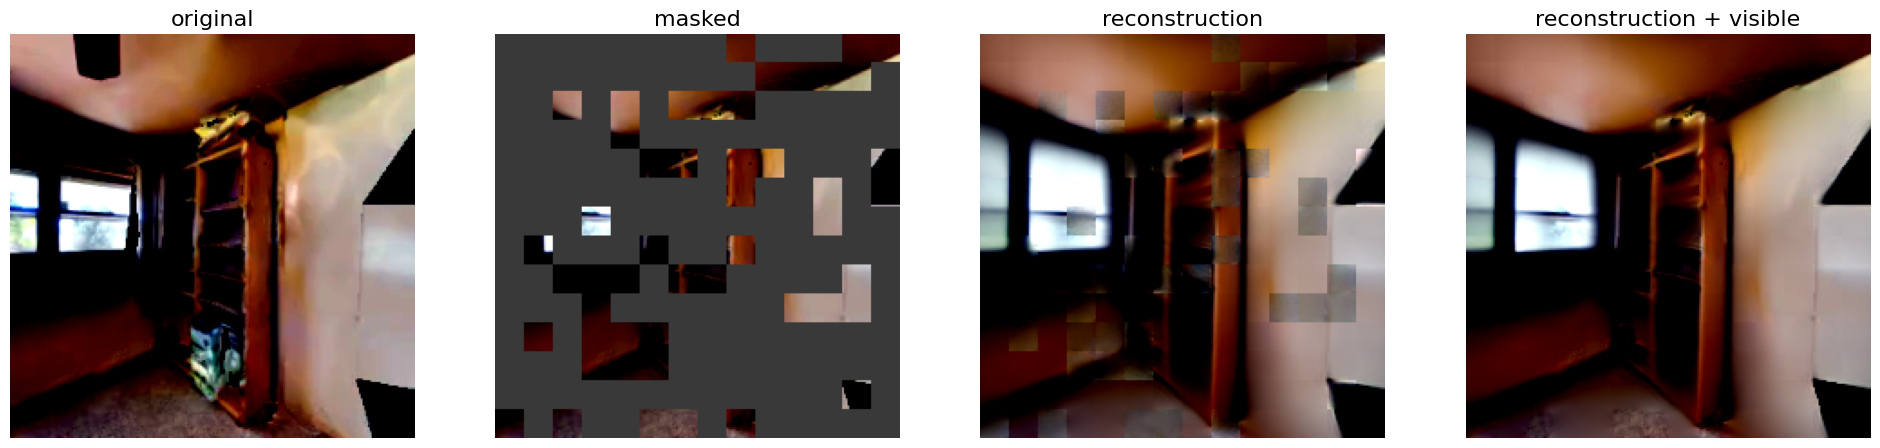

Mean Squared Error: 0.3641229271888733
Mean Absolute Error: 0.3319564759731293
SSIM: 0.4913163185119629
PSNR: 4.387519746279127


<ipython-input-19-dc28acf8314d>:14: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_val = ssim(y_true[0], y_pred[0], multichannel=True)


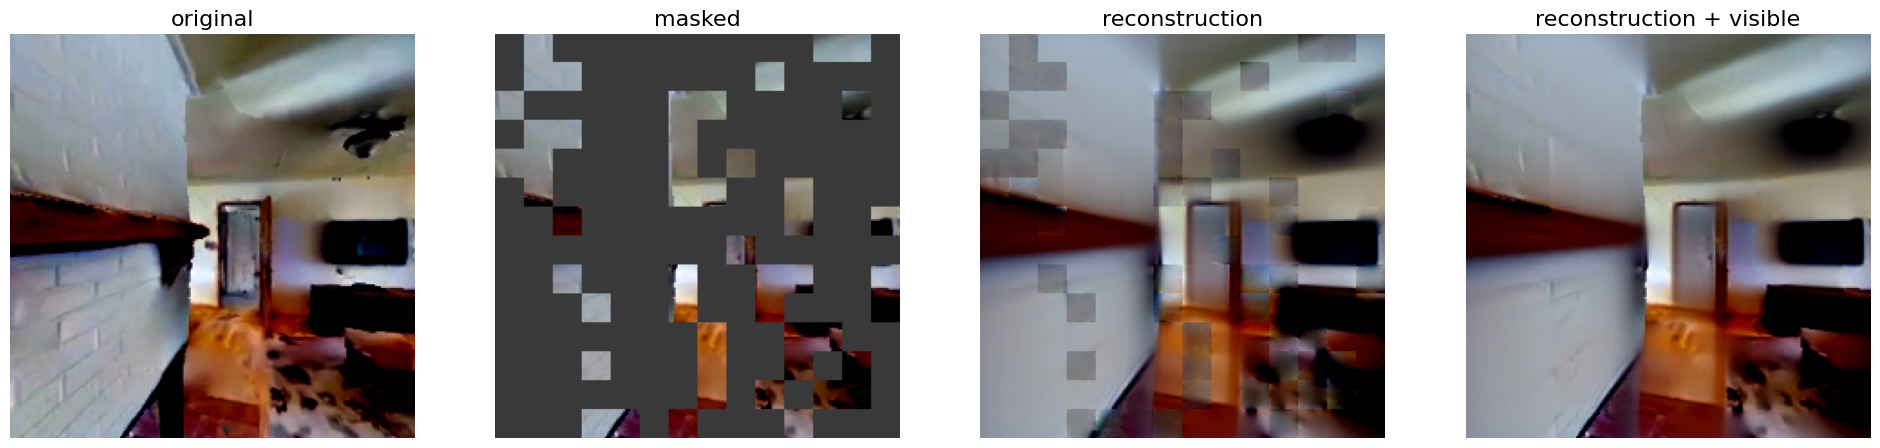

Mean Squared Error: 0.12209035456180573
Mean Absolute Error: 0.21315997838974
SSIM: 0.49423083662986755
PSNR: 9.1331864503176


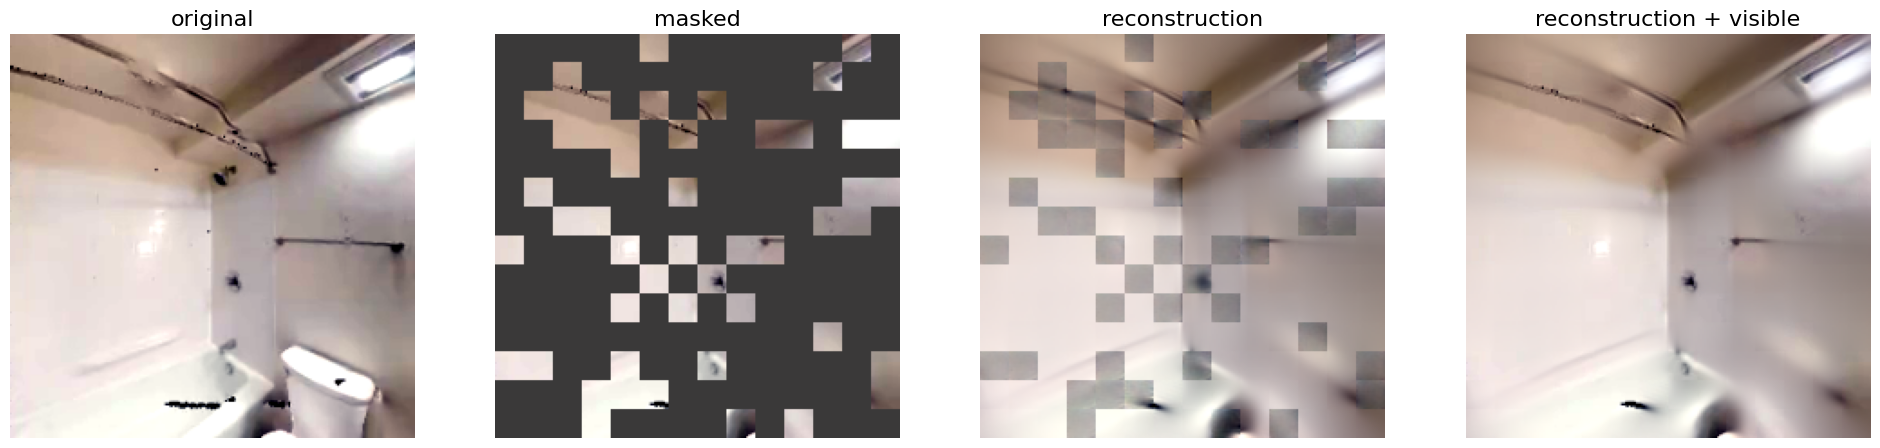

Mean Squared Error: 0.09390678256750107
Mean Absolute Error: 0.17833276093006134
SSIM: 0.6105042099952698
PSNR: 10.273030389877782


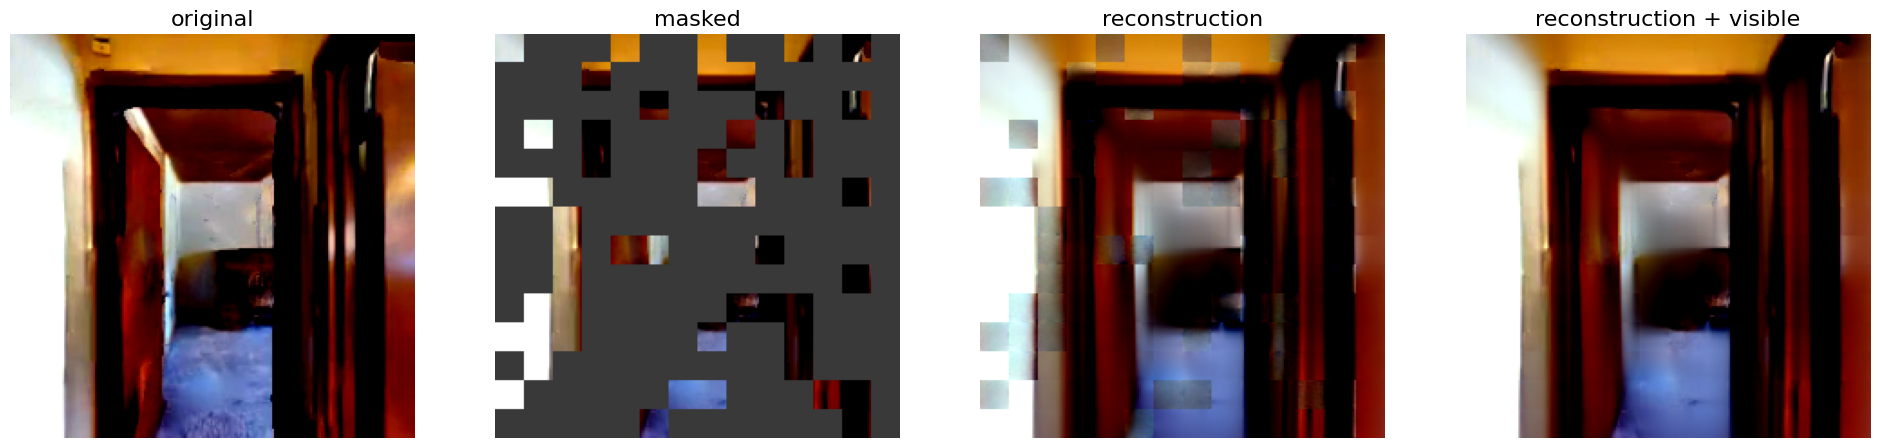

Mean Squared Error: 0.19198931753635406
Mean Absolute Error: 0.29581424593925476
SSIM: 0.4689810574054718
PSNR: 7.167229351718703


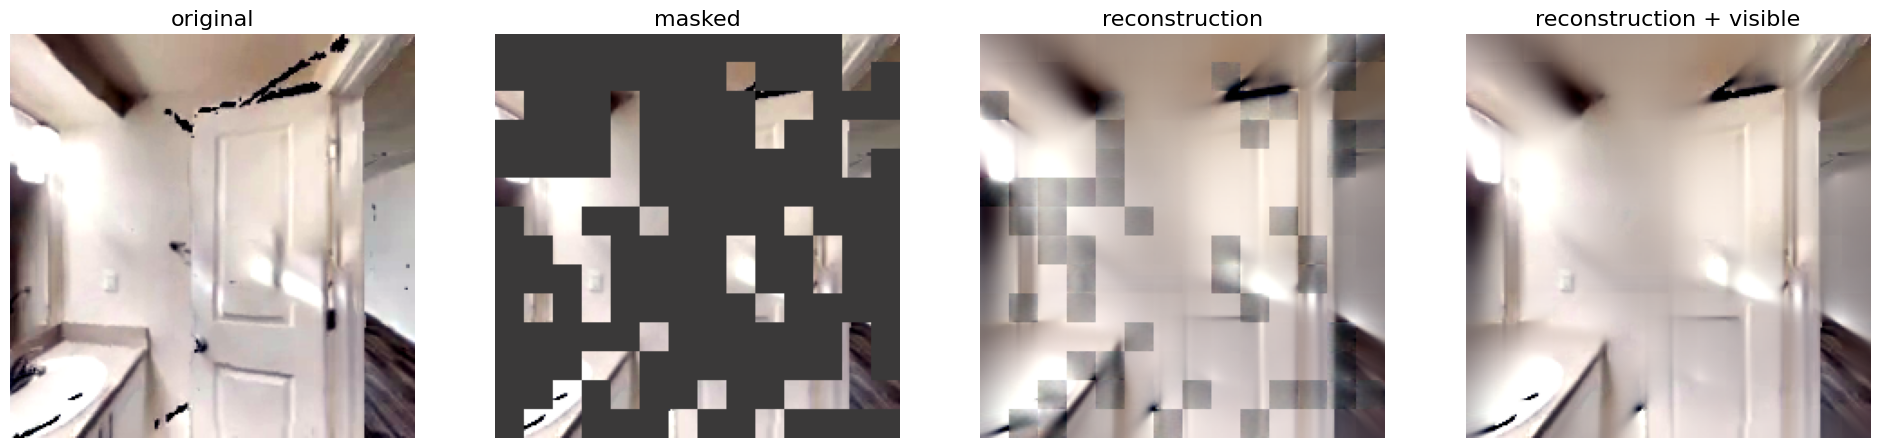

Mean Squared Error: 0.1579987108707428
Mean Absolute Error: 0.25618427991867065
SSIM: 0.5001620650291443
PSNR: 8.013464564886586


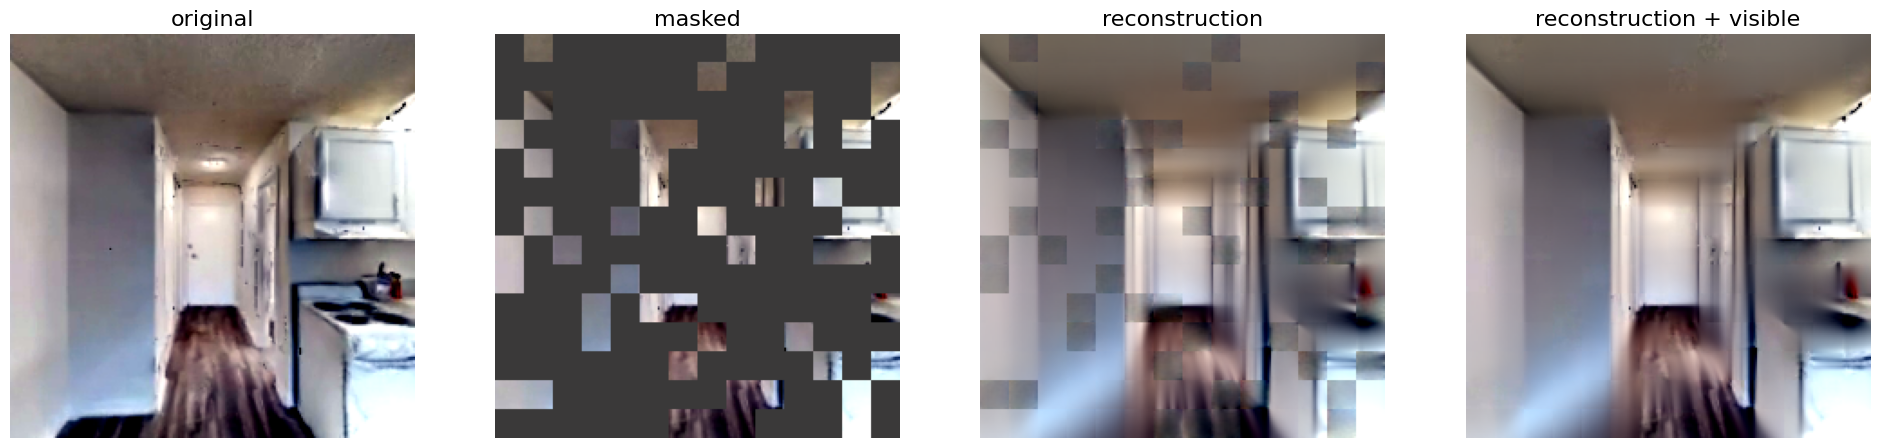

Mean Squared Error: 0.12214008718729019
Mean Absolute Error: 0.19836141169071198
SSIM: 0.5722479224205017
PSNR: 9.131417743274996


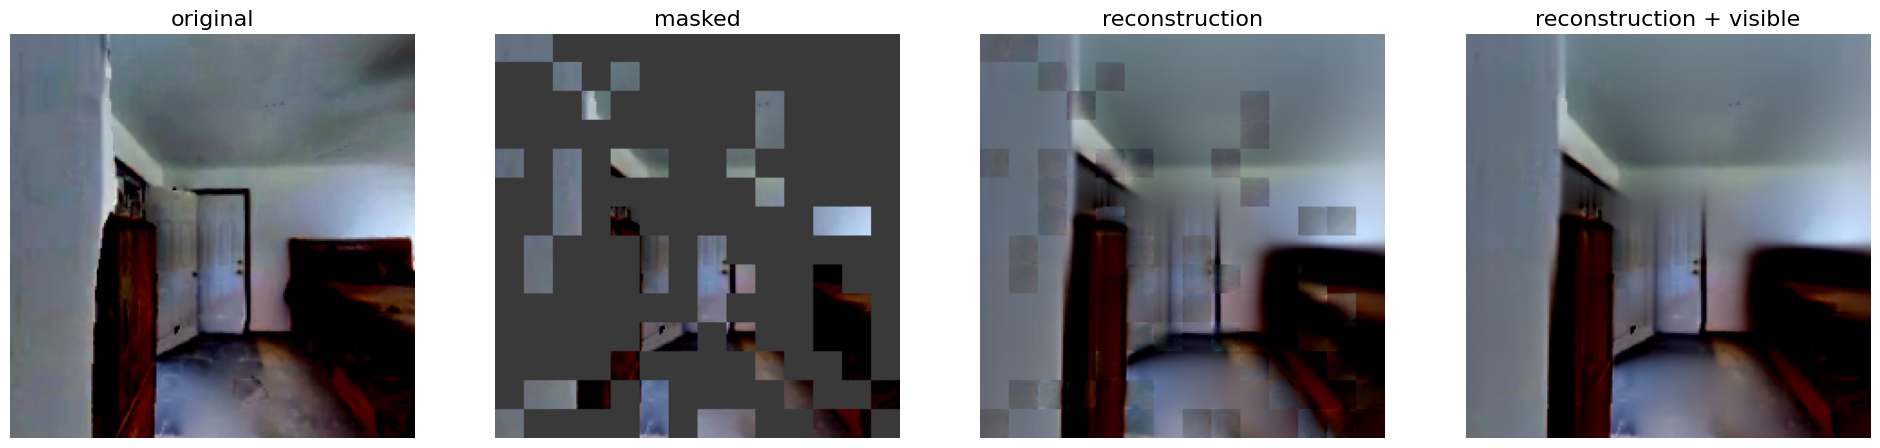

Mean Squared Error: 0.0809750109910965
Mean Absolute Error: 0.16529957950115204
SSIM: 0.6030856966972351
PSNR: 10.9164898436907


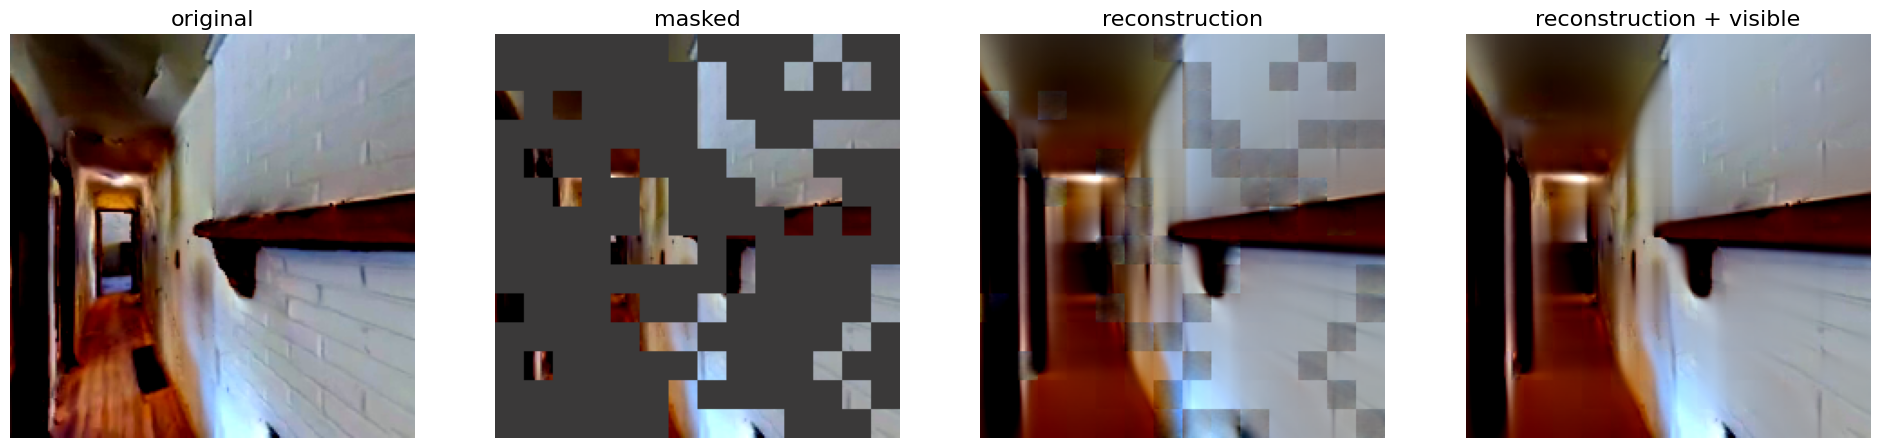

Mean Squared Error: 0.11165504157543182
Mean Absolute Error: 0.215749591588974
SSIM: 0.4867502450942993
PSNR: 9.521216623914025


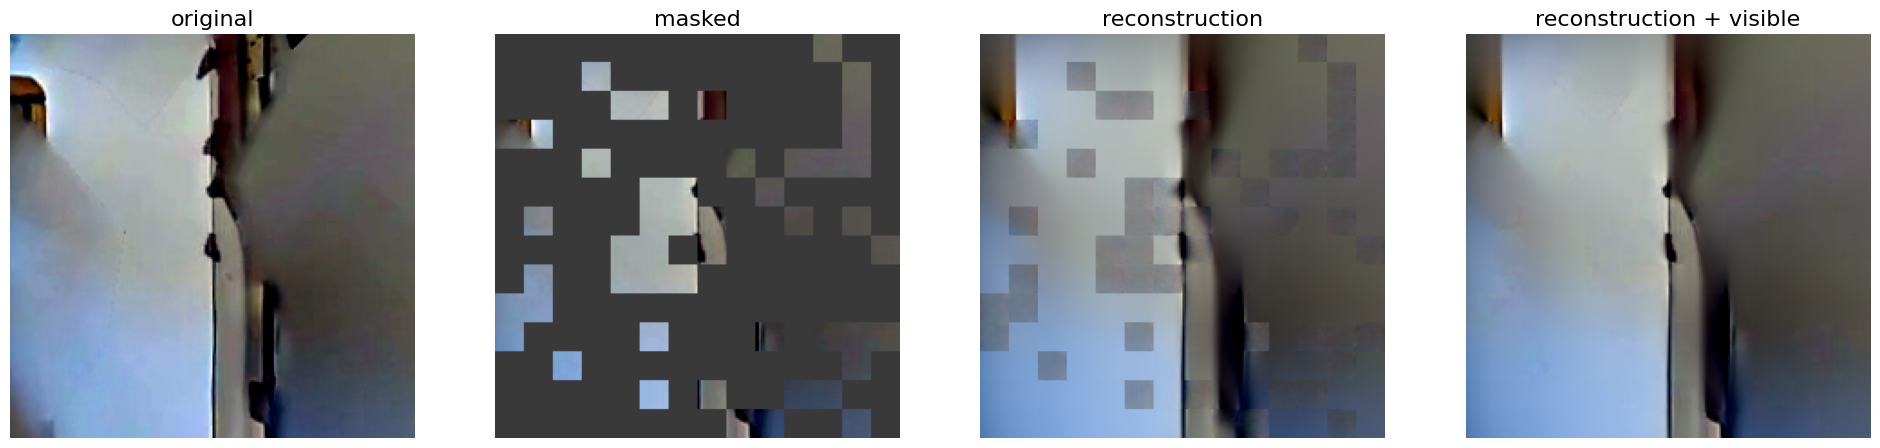

Mean Squared Error: 0.06441694498062134
Mean Absolute Error: 0.1243363693356514
SSIM: 0.6823108196258545
PSNR: 11.909998757522706


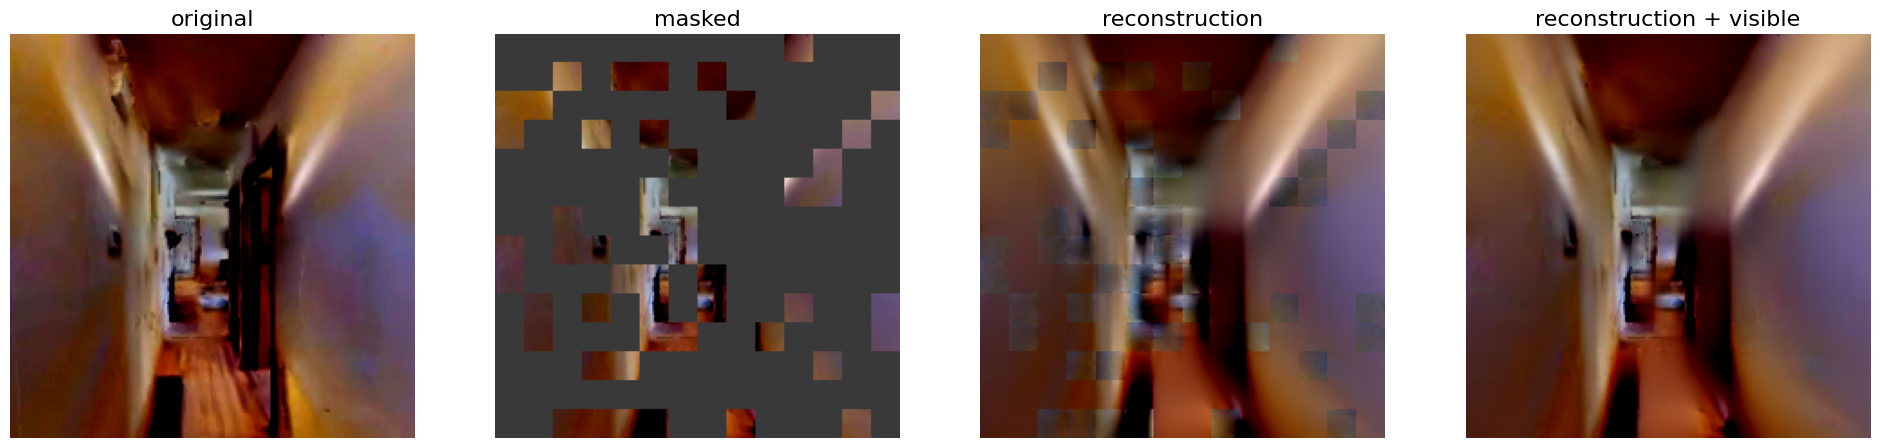

Mean Squared Error: 0.09567385166883469
Mean Absolute Error: 0.17161330580711365
SSIM: 0.5468094348907471
PSNR: 10.192067417178492


In [ ]:
# Loading the fine-tuned model (not frozen)
fine_tuned_model = ViTMAEForPreTraining.from_pretrained("lucazed/habitat_fine_tuned_vit_mae_base_not_frozen")

imagenet_mean = np.array(feature_extractor.image_mean)
imagenet_std = np.array(feature_extractor.image_std)

test_images = image_paths_test # List of test images

count = 0
for image in test_images:
  count += 1
  test_data = Image.open(image)
  test_pixel_values = feature_extractor(images=test_data, return_tensors="pt").pixel_values
  test_pixel_values = test_pixel_values.to(device)
  visualize(test_pixel_values, fine_tuned_model, imagenet_mean, imagenet_std)
  if count == 10:
    break

The procedure to compute the embeddings is shown in the cell below.

In [ ]:
# Using the encoder to compute embeddings
encoder = fine_tuned_model.vit
encoder.eval()

# Example of using the encoder to compute embeddings
with torch.no_grad():
    image_embeddings = encoder(test_pixel_values).last_hidden_state[:, 0]

We now compute the metrics for the three models (baseline, finetuned with all layers unfrozen, finetuned with all layers but one frozen), in order to determine whether finetuning allows to obtain better results.

In [ ]:
# Load the baseline model
baseline_model = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")
baseline_model.to(device)

# Load the fine-tuned model (not frozen)
fine_tuned_model_not_frozen = ViTMAEForPreTraining.from_pretrained("lucazed/habitat_fine_tuned_vit_mae_base_not_frozen")
fine_tuned_model_not_frozen.to(device)

# Load the fine-tuned model (frozen)
fine_tuned_model_frozen = ViTMAEForPreTraining.from_pretrained("lucazed/habitat_fine_tuned_vit_mae_base_frozen")
fine_tuned_model_frozen.to(device)

# Prepare a set of test images
test_images = image_paths_test # List of test images

# Function to evaluate a model on a set of test images
def evaluate_model(model, test_images):
    mse_total = 0
    mae_total = 0
    ssim_total = 0
    psnr_total = 0
    num_images = len(test_images)

    for image in test_images:
        image = Image.open(image)
        test_pixel_values = feature_extractor(images=image, return_tensors="pt").pixel_values
        test_pixel_values = test_pixel_values.to(device)

        # Compute the reconstruction using the given model
        with torch.no_grad():
            outputs = model(test_pixel_values)
            reconstructions = model.unpatchify(outputs.logits)

        # Compute the metrics
        mse = mse_loss(test_pixel_values, reconstructions).item()
        mae = mae_loss(test_pixel_values, reconstructions).item()
        ssim = calculate_ssim(test_pixel_values, reconstructions)
        psnr = calculate_psnr(test_pixel_values, reconstructions)

        mse_total += mse
        mae_total += mae
        ssim_total += ssim
        psnr_total += psnr

    # Compute the average metrics
    mse_avg = mse_total / num_images
    mae_avg = mae_total / num_images
    ssim_avg = ssim_total / num_images
    psnr_avg = psnr_total / num_images

    return mse_avg, mae_avg, ssim_avg, psnr_avg

# Evaluate the baseline model
baseline_mse, baseline_mae, baseline_ssim, baseline_psnr = evaluate_model(baseline_model, test_images)

# Evaluate the fine-tuned model (not frozen)
fine_tuned_not_frozen_mse, fine_tuned_not_frozen_mae, fine_tuned_not_frozen_ssim, fine_tuned_not_frozen_psnr = evaluate_model(fine_tuned_model_not_frozen, test_images)

# Evaluate the fine-tuned model (frozen)
fine_tuned_frozen_mse, fine_tuned_frozen_mae, fine_tuned_frozen_ssim, fine_tuned_frozen_psnr = evaluate_model(fine_tuned_model_frozen, test_images)

# Compare the results
print(f"Baseline - MSE: {baseline_mse}, MAE: {baseline_mae}, SSIM: {baseline_ssim}, PSNR: {baseline_psnr}")
print(f"Fine-tuned (not frozen) - MSE: {fine_tuned_not_frozen_mse}, MAE: {fine_tuned_not_frozen_mae}, SSIM: {fine_tuned_not_frozen_ssim}, PSNR: {fine_tuned_not_frozen_psnr}")
print(f"Fine-tuned (frozen) - MSE: {fine_tuned_frozen_mse}, MAE: {fine_tuned_frozen_mae}, SSIM: {fine_tuned_frozen_ssim}, PSNR: {fine_tuned_frozen_psnr}")

<ipython-input-19-dc28acf8314d>:14: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_val = ssim(y_true[0], y_pred[0], multichannel=True)


Baseline - MSE: 0.13608262582577868, MAE: 0.21820074750983215, SSIM: 0.5281118056053048, PSNR: 9.104766173805938
Fine-tuned (not frozen) - MSE: 0.13741410363439496, MAE: 0.21901210775221144, SSIM: 0.5274752794237404, PSNR: 9.091592890447012
Fine-tuned (frozen) - MSE: 0.13540920654923974, MAE: 0.2181033311294509, SSIM: 0.5290902663360942, PSNR: 9.15698452795023
